# Walk Forward Analysis (Framework)
### Abstract:
Walk forward analysis (WFA), or walk forward optimization (WFO) is a method used to optimize trading strategies. It involves dividing historical data into segments and testing the strategy on each segment, then re-optimizing the parameters for the next segment. This ensures that the strategy adapts to changing market conditions and avoids overfitting.

### Doing it with TradingView's deep-backtesting feature:
TradingView does not provide this feature, so we need to manually obtain in-sample datasets (see prerequisites section below). After the manual process is complete, we can use Python to combine the Out of Sample periods (OOS) and visualize the performance of a strategy that had adopted different settings over historical time.

### Prerequisites:
Before running this script, you should have:
* A TradingView Premium account for accessing the "deep backtesting" feature and setting in-sample periods. This allows you to manually tested all combinations of strategy settings for in-sample periods.
* A dataset containing in-sample trade performance. In this notebook, we are using "List_of_Trades" .csv file that is generated by TradingView's built-in backtester.

### Example Strategy:
Here are the properties of the strategy used for illustrative purposes:
* Trend following, adds to existing winning position
* Risking USD1 per NASDAQ point movement (think of a "Half MNQ". You will multiply the results by 2 if you're trading MNQ, and 20 if it's NQ)
* Session: 0945-1545 EST

##### Strat Settings

* In this WFO, we will adjust the "brick size" parameters on a weekly basis to optimize the in-sample (IS) periods. Rest are fixed.
* Out-of-sample periods will follow IS by taking the average of args on a rolling basis. Surely, there must be more clever ways to do it by appling ML, but I'm not an expert in this domain of practice.

[   
    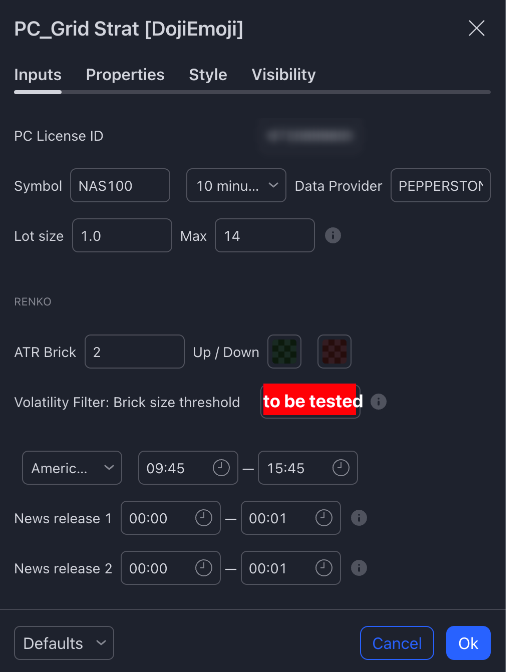
]



# Implementation

In [1]:
import pandas as pd
import os
import numpy as np
import regex as re
import datetime
import matplotlib.pyplot as plt
import random

In [2]:
VERBOSE = False
OOS_LOOKBACK = 4 # weeks
REPO_PATH = r"../../../../Backtest WFA Data/Dataset 004.repo/."

# String representation of parameters for grouping datasets
STR_PARMS = "ATR={}; Brick={}"

# Field names
PARAM1_BRICK = "Volatility Filter: Brick size threshold" 
PARAM1_FLOOR = -999 
PARAM1_CAP   = 999 

PARAM2_ATRLEN = "ATR Brick" 
PARAM2_FLOOR = -999 
PARAM2_CAP   = 999 


## Preprocessing

* Iterate through folders. Naming convention is "arg1"_"arg2"; where: arg1 is "ATR length", and arg2 is "Volatility filter"; 
* Result -> df_main

In [3]:
_df_consol_trades = []

# Read the properties file and trades file and consolidate them into one dataframe
os.chdir(REPO_PATH)
for folder in os.listdir('.'): 

    # Iterate through subfolders && Search element in os.listdir(folder) that contains "_Properties_" and ".csv" 
    if os.path.isdir(folder): 
        for file in os.listdir(folder):
            if file.endswith(".csv") and "_Properties_" in file:
                file_properties = os.path.join(folder, file) 
            elif file.endswith(".csv") and "_List_of_Trades_" in file:
                file_trades = os.path.join(folder, file)   

        # Read the properties file. Followed by checking data integrity.
        df = pd.read_csv(file_properties)
        df.set_index("Title", inplace=True)
        df = df.T 
        
        _atr_len = int(df[PARAM2_ATRLEN].iloc[0])
        _brick_limit = int(df[PARAM1_BRICK].iloc[0])
        assert folder == str(_atr_len) + "_" + str(_brick_limit),\
            "Folder name does not correspond to arguments in properties file; folder={}".format(folder)
        
        # Read the trade file
        if _brick_limit <= PARAM1_CAP and _brick_limit >= PARAM1_FLOOR:
            df_sub = pd.read_csv(file_trades) 
            df_sub['Params'] = STR_PARMS.format(_atr_len, _brick_limit)
            _df_consol_trades.append(df_sub)

df_consol_trades = pd.concat(_df_consol_trades, ignore_index=True)
# df_consol_trades.head()


def clean_data(df_listoftrades):
    ''' Helper function to clean df_consol_trades. '''
    df_listoftrades = df_listoftrades[df_listoftrades['Type'].str.contains("Exit", na=False)] # Becuase we only want the exit trades, and since entry rows also contain the profit value, including it will cause double count issues
    df_listoftrades = df_listoftrades.astype({'Date/Time': 'datetime64[ns]'})
    _irrelevant_columns = ['Profit %', 'Cum. Profit USD', 'Cum. Profit %', 'Run-up USD', 'Run-up %', 'Drawdown USD', 'Drawdown %', 'Trade #']
    df_listoftrades = df_listoftrades.drop(columns=_irrelevant_columns)
    df_listoftrades = df_listoftrades.sort_index(ascending=False)
    df_listoftrades = df_listoftrades.sort_values(by="Date/Time", ascending=True)

    return df_listoftrades

# Cleaned dataframe
df_consol_trades_clean = clean_data(df_consol_trades)
print("Cleaned dataframe; shape={}:".format(df_consol_trades_clean.shape))
# df_consol_trades_clean.head()


# -----------------------------------------------
# Categorize in-sample group based on given date
# -----------------------------------------------

# df_main = df_consol_trades_clean + new grouping columns "In-sample Group" and "In-sample Group + Params" 

def _categorize_in_sample(date):
    ''' Helper function to categorize in-sample group based on given date. '''
    year, week_num, day_of_week = date.isocalendar()
    return str(year) + "_Week #{:02d}".format(week_num)


# Initialize df_main, which is the main dataframe that will be used for further analysis
df_main = df_consol_trades_clean.copy()

# Add week number
df_main['In-sample Group'] = df_main['Date/Time'].apply(lambda x: _categorize_in_sample(x)) 
df_main.reset_index(inplace=True)
# df_main.head()

# Aggregated by "in-sample group and params" and summed by "profit usd"
df_main["In-sample Group + Params"] = df_main["In-sample Group"].astype(str) + " / " + df_main["Params"].astype(str)
df_main.groupby("In-sample Group + Params").agg({"Profit USD": "sum"}).reset_index() 
df_main.head()

Cleaned dataframe; shape=(212611, 7):


,index,Type,Signal,Date/Time,Price USD,Contracts,Profit USD,Params,In-sample Group,In-sample Group + Params
0,425220,Exit Short,Reverse,2014-07-28 11:10:00,3953.2,1,-10.0,ATR=2; Brick=50,2014_Week #31,2014_Week #31 / ATR=2; Brick=50
1,31286,Exit Short,Reverse,2014-07-28 11:10:00,3953.2,1,-10.0,ATR=2; Brick=14,2014_Week #31,2014_Week #31 / ATR=2; Brick=14
2,316908,Exit Short,Reverse,2014-07-28 11:10:00,3953.2,1,-10.0,ATR=2; Brick=45,2014_Week #31,2014_Week #31 / ATR=2; Brick=45
3,230516,Exit Short,Reverse,2014-07-28 11:10:00,3953.2,1,-10.0,ATR=2; Brick=44,2014_Week #31,2014_Week #31 / ATR=2; Brick=44
4,322068,Exit Short,Reverse,2014-07-28 11:10:00,3953.2,1,-13.6,ATR=2; Brick=11,2014_Week #31,2014_Week #31 / ATR=2; Brick=11


In [4]:
# For validation of the dataset; TODO: manually check by eye
df_main[df_main['Params']=='ATR=2; Brick=15']['Profit USD'].sum()

3123.9000000000005

In [5]:
set(df_main['Type'])

{'Exit Long', 'Exit Short'}

In [6]:
set(df_main['Signal'])

{'Reverse', 'SL - Potential News', 'TP - Potential News', 'Too volat.', 'end'}

## Optimizing IS stages + building OOS Template:
* Based on df_main
* Result -> df_wfa_template; a dataframe containing optimized parameters for the in-sample periods

In [7]:
_list_grouping  = []
_list_bricksize = []
_list_atrlen    = []
_list_benchmark = []

_count = 0
_total_count = len(df_main["In-sample Group"].unique())

# Iterate by In-sample Group (e) and "In-sample Group + Params" (f)
for e in df_main["In-sample Group"].unique():
    _count += 1
    print("Processing: {}/{}".format(_count, _total_count), end="\r")
    if VERBOSE:
        print("\nIn-sample period: " + e)
    tmp = df_main[df_main["In-sample Group"] == e]
    
    # Find best performance
    __best_benchmark = None
    __best_group = None # String representation of params: e "Brick=20, ATR=5"

    for f in tmp["In-sample Group + Params"].unique():

        _median = tmp[tmp["In-sample Group + Params"] == f]["Profit USD"].median()
        benchmark = _median # medians, less sensitive to outliers 
        
        if VERBOSE:
            print(">>> {} \tMedian={},\tbenchmark={}".format(f, _median, round(benchmark,2)))

        if (__best_benchmark is None and __best_group is None) or (benchmark > __best_benchmark):
            __best_benchmark = benchmark
            __best_group = f

    assert __best_group is not None, "Unexpected: __best_group is None"
    
    if VERBOSE:
        print("Best Group: {};\tBenchmark={}".format(__best_group, __best_benchmark))
    
    # Extract digts in _best_group after "Brick=", and "ATR=", store in tuple
    _best_brick = int(re.findall(r"Brick=(\d+)", __best_group)[0])
    _best_atr = int(re.findall(r"ATR=(\d+)", __best_group)[0]) 
    _list_grouping.append(e)
    _list_bricksize.append(_best_brick)
    _list_atrlen.append(_best_atr)
    _list_benchmark.append(benchmark)

In [8]:
# ----------------------------------------------------
# Helper functions
# ----------------------------------------------------

def _yyyy_weekNo_to_date(year, week_number): 
    d = str(year) + '-W' + str(week_number)
    r = datetime.datetime.strptime(d + '-1', "%Y-W%W-%w")
    return r.strftime('%Y-%m-%d')

def _find_nearest(array, value):
    if value is None or np.isnan(value):
        return None 

    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# ----------------------------------------------------

# A dataframe that outlines the walk-forward analysis (WFA)
df_wfa_template = pd.DataFrame({"In-sample Period": _list_grouping, "IS: Brick": _list_bricksize, "IS: ATR": _list_atrlen, "benchmark" : _list_benchmark}) 

# Extract the year from the string and store it in a new column
df_wfa_template['Year'] = df_wfa_template['In-sample Period'].str.extract('(\d+)')
df_wfa_template['Week Number'] = df_wfa_template['In-sample Period'].str.extract('#(\d+)').astype(int)
df_wfa_template['IS: Date1'] = df_wfa_template.apply(lambda x: _yyyy_weekNo_to_date(x['Year'], x['Week Number']), axis=1)

# Cast Date1 to datetime and add 6 days to it to get Date2
df_wfa_template['IS: Date1'] = pd.to_datetime(df_wfa_template['IS: Date1']) 
df_wfa_template['IS: Date2'] = df_wfa_template['IS: Date1'] + pd.DateOffset(days=6)

# Re-arrange columns
df_wfa_template.drop(columns=['Year', 'Week Number'], inplace=True)
df_wfa_template = df_wfa_template[['In-sample Period', 'IS: Date1', 'IS: Date2', 'IS: Brick', 'IS: ATR', 'benchmark']]

# Insert column OOS Date1, which is Date2 + 1 day; OOS Date2 is OOS Date1 + 6 days
df_wfa_template['OOS Date1'] = df_wfa_template['IS: Date2'] + pd.DateOffset(days=1)
df_wfa_template['OOS Date2'] = df_wfa_template['OOS Date1'] + pd.DateOffset(days=6)

# Calculate the rolling average of ATR and Brick, and add them to the dataframe as new columns. Apply _find_nearest() to both columns
df_wfa_template['OOS ATR'] = df_wfa_template['IS: ATR'].rolling(window=OOS_LOOKBACK).mean()
df_wfa_template['OOS Brick'] = df_wfa_template['IS: Brick'].rolling(window=OOS_LOOKBACK).mean()
df_wfa_template['OOS ATR'] = df_wfa_template['OOS ATR'].apply(lambda x: _find_nearest(np.array(df_wfa_template['IS: ATR'].unique()), x))
df_wfa_template['OOS Brick'] = df_wfa_template['OOS Brick'].apply(lambda x: _find_nearest(np.array(df_wfa_template['IS: Brick'].unique()), x))

# 
df_wfa_template.head()

,In-sample Period,IS: Date1,IS: Date2,IS: Brick,IS: ATR,benchmark,OOS Date1,OOS Date2,OOS ATR,OOS Brick
0,2014_Week #31,2014-08-04,2014-08-10,5,2,-1.90,2014-08-11,2014-08-17,NaN,NaN
1,2014_Week #32,2014-08-11,2014-08-17,9,2,-6.80,2014-08-18,2014-08-24,NaN,NaN
2,2014_Week #33,2014-08-18,2014-08-24,5,2,2.65,2014-08-25,2014-08-31,NaN,NaN
3,2014_Week #34,2014-08-25,2014-08-31,11,2,0.25,2014-09-01,2014-09-07,2.0,8.0
4,2014_Week #35,2014-09-01,2014-09-07,5,2,-3.50,2014-09-08,2014-09-14,2.0,8.0


## Populating OOS Dataframe

In [9]:
_df_oos = df_wfa_template.copy()[['OOS Date1','OOS Date2','OOS ATR','OOS Brick']] # temp df, for displaying OOS settings in this cell only
list_of_trades = [] # initialize empty list to store trades forming OOS equity curve

for i in range(len(_df_oos)):

    _oos_atr = _df_oos['OOS ATR'][i]
    _oos_brick = _df_oos['OOS Brick'][i]
    _date1 = _df_oos['OOS Date1'][i] 
    _date2 = _df_oos['OOS Date2'][i]

    if not np.isnan(_oos_atr) and not np.isnan(_oos_brick):
        if VERBOSE:
            print("Combining OOS period:  {}  to  {}".format(_date1.strftime('%Y-%m-%d'), _date2.strftime('%Y-%m-%d')))

        # Based on df_main 
        _filter_param = STR_PARMS.format(int(_oos_atr), int(_oos_brick))

        if VERBOSE:
            print("  Filtering: {}".format(_filter_param))

        _param_mask = df_main["Params"]==_filter_param
        _df = df_main[_param_mask & (_date1 <= df_main['Date/Time']) & (df_main['Date/Time'] <= _date2)]

        if len(_df) > 0:
            list_of_trades.append(_df)

In [10]:
# Concate all the trades into one dataframe    
df_oos_equitycurve = pd.concat(list_of_trades)
print(df_oos_equitycurve.shape) 

df_oos_equitycurve.sort_values(by="Date/Time", inplace=True)
df_oos_equitycurve["Accum PL"] = df_oos_equitycurve["Profit USD"].cumsum()
df_oos_equitycurve['Drawdown'] = df_oos_equitycurve['Accum PL'] - df_oos_equitycurve['Accum PL'].cummax()

df_oos_equitycurve.set_index("Date/Time", inplace=True)
df_oos_equitycurve.tail()

(3844, 10)


,index,Type,Signal,Price USD,Contracts,Profit USD,Params,In-sample Group,In-sample Group + Params,Accum PL,Drawdown
Date/Time,,,,,,,,,,,
2023-07-19 15:50:00,277338,Exit Long,end,15826.8,1,-33.1,ATR=2; Brick=28,2023_Week #29,2023_Week #29 / ATR=2; Brick=28,7244.7,-105.1
2023-07-25 13:50:00,81220,Exit Long,TP - Potential News,15579.4,1,12.3,ATR=2; Brick=24,2023_Week #30,2023_Week #30 / ATR=2; Brick=24,7257.0,-92.8
2023-07-25 15:50:00,81218,Exit Long,end,15558.9,1,-39.7,ATR=2; Brick=24,2023_Week #30,2023_Week #30 / ATR=2; Brick=24,7217.3,-132.5
2023-07-26 13:50:00,81216,Exit Short,SL - Potential News,15448.6,1,-5.0,ATR=2; Brick=24,2023_Week #30,2023_Week #30 / ATR=2; Brick=24,7212.3,-137.5
2023-07-28 13:20:00,81214,Exit Long,Reverse,15721.2,1,-54.8,ATR=2; Brick=24,2023_Week #30,2023_Week #30 / ATR=2; Brick=24,7157.5,-192.3


# Results

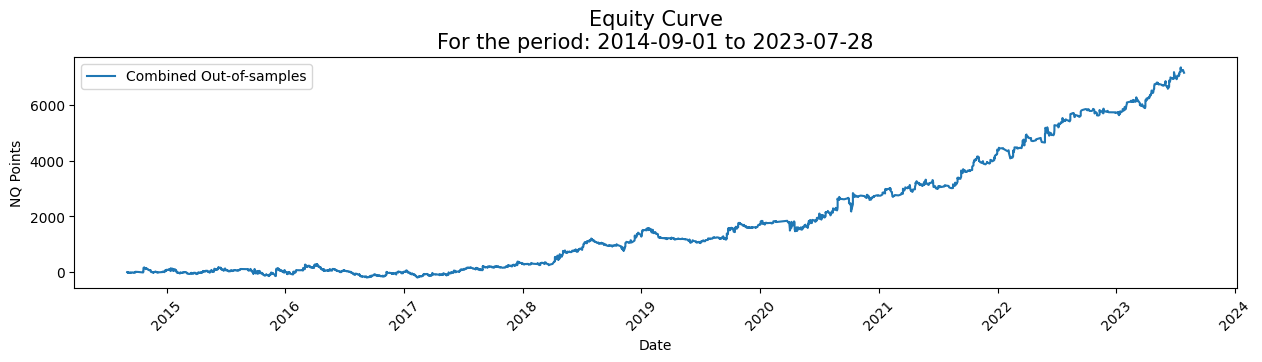

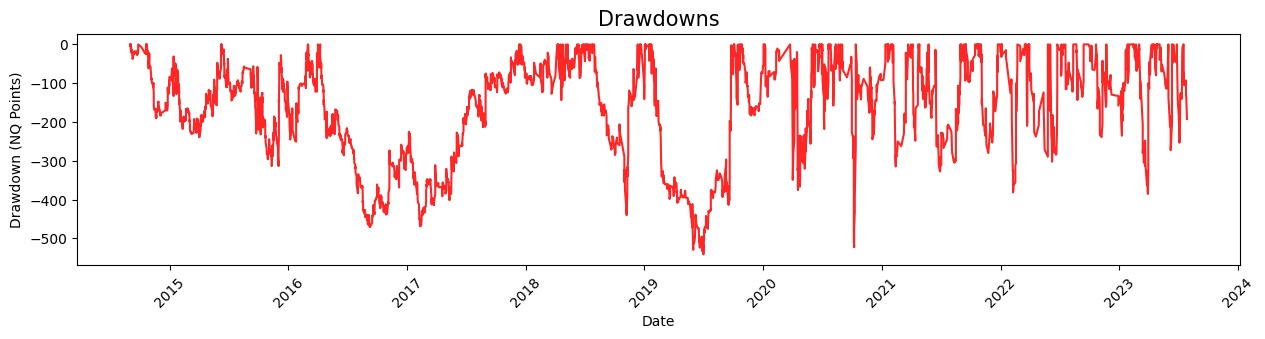

********************
 Daily stats:
********************
Win rate = 0.5159
Winning days = 0.4603


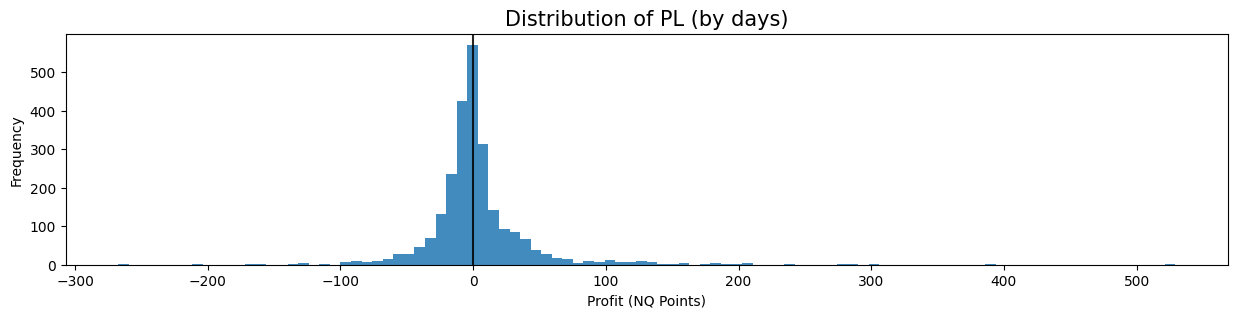

In [11]:
def plot_equity_curve(df, remarks="", figsize=(15,3)):
    ''' Helper function to plot equity curve and drawdowns '''
    if remarks != "":
        remarks = "\n" + remarks
    
    # Equity Curve
    plt.figure(figsize=figsize)
    plt.plot(df['Accum PL'], label="Combined Out-of-samples")
    title = "Equity Curve" + remarks
    plt.title(title, size=15)
    plt.xlabel("Date")
    plt.ylabel("NQ Points")

    # Rotate x-axis labels
    plt.xticks(rotation=45)
    plt.legend(loc="upper left")


    # Drawdown underwater plot
    plt.figure(figsize=figsize)
    plt.plot(df["Drawdown"], color="red", alpha=0.85)
    plt.title("Drawdowns", size=15)
    plt.xlabel("Date")
    plt.ylabel("Drawdown (NQ Points)")

    # Rotate x-axis labels
    plt.xticks(rotation=45)

    plt.show()

# Plot the entire equity curve

_first_day = df_oos_equitycurve.index[0].strftime("%Y-%m-%d")
_last_day = df_oos_equitycurve.index[-1].strftime("%Y-%m-%d")
plot_equity_curve(df_oos_equitycurve, remarks="For the period: {} to {}".format(_first_day, _last_day)) 

# ----------------------------------
# Aggregate by day
# ----------------------------------
df_pl_daily = df_oos_equitycurve.copy()
df_pl_daily = df_pl_daily.groupby(['Date/Time']).agg({'Profit USD':'sum'})

print("*"*20)
print(" Daily stats:")
print("*"*20)
print("Win rate = " + str(round(len(df_oos_equitycurve[df_oos_equitycurve["Profit USD"] > 0]) / len(df_oos_equitycurve),4)))
print("Winning days = " + str(round(len(df_pl_daily[df_pl_daily["Profit USD"] > 0]) / len(df_pl_daily),4)))
df_pl_daily.describe()[:3]

fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot(1, 1, 1)

ax.hist(df_pl_daily['Profit USD'], bins=100, alpha=0.85)

# Plot 0 line
ax.axvline(x=0, color='black', alpha=0.85)

ax.set_title('Distribution of PL (by days)', size=15)
ax.set_xlabel('Profit (NQ Points)')
ax.set_ylabel('Frequency') 

plt.show()


**Acceptability** of strategy: 
* If, and only if, the upside (on the right-tail of the Distribution) is larger.

## Patterns (if any) of best parameters

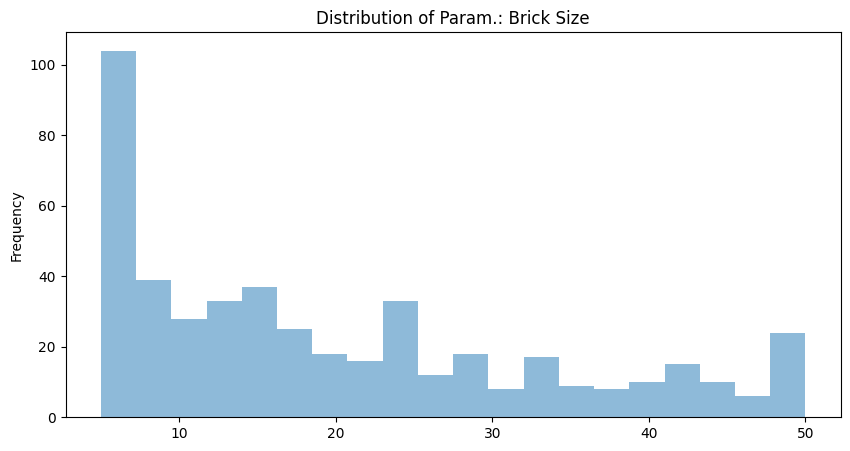

Observation 1: When not considering time, the distribution of brick size is skewed to the right.


In [12]:
df = df_wfa_template.copy()

df['IS: Brick'].plot(kind='hist', bins=20, title='Distribution of Param.: Brick Size', figsize=(10, 5), alpha=0.5)
plt.show()
print("Observation 1: When not considering time, the distribution of brick size is skewed to the right.")

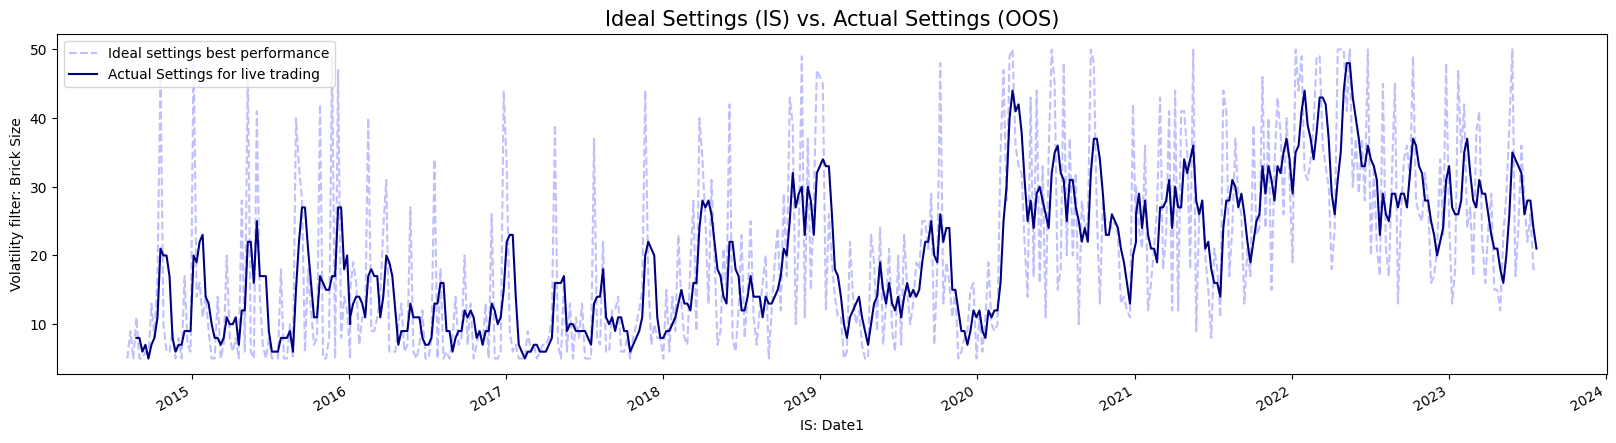

Observation 2: Optimal args for parameter 'brick_size' is volatile. This strategy needs to be frequently adjusted. 
More studies are needed to determine whether there is a correlation between it and the realized (or expected) market volatility.


In [13]:
df = df_wfa_template.copy()
df.sort_values(by=['IS: Date1'], inplace=True) 
df.set_index('IS: Date1', inplace=True) 

df['IS: Brick'].plot(kind='line', figsize=(20, 5), alpha=0.25, label='Ideal settings best performance', color='blue', linestyle='--')
df['OOS Brick'].plot(kind='line', figsize=(20, 5), label='Actual Settings for live trading', color='navy')
plt.legend(loc='upper left')
plt.ylabel('Volatility filter: Brick Size')
plt.title('Ideal Settings (IS) vs. Actual Settings (OOS)', size=15)
plt.show()
print("Observation 2: Optimal args for parameter 'brick_size' is volatile. This strategy needs to be frequently adjusted. \nMore studies are needed to determine whether there is a correlation between it and the realized (or expected) market volatility.") 

# Drilling down, examining recent trades in 1H of FY23 

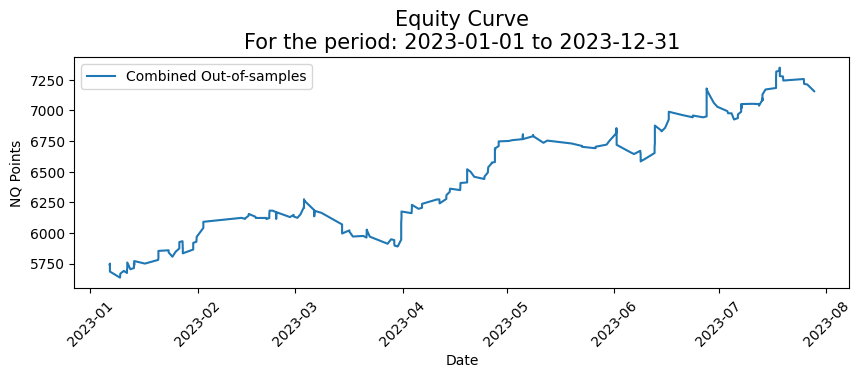

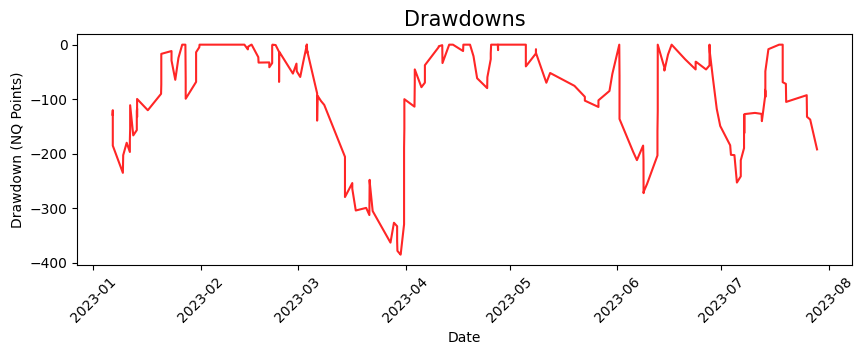

In [14]:
__from = "2023-01-01"
__to = "2023-12-31"

# Plot a specific date range
_date_mask = (df_oos_equitycurve.index >= __from) & (df_oos_equitycurve.index <= __to)
plot_equity_curve(df_oos_equitycurve[_date_mask], remarks=f"For the period: {__from} to {__to}", figsize=(10,3))

In [15]:
# Display recent trades
_date_mask = (df_wfa_template['OOS Date1'] >= __from) & (df_wfa_template['OOS Date1'] <= __to)
df_wfa_template[_date_mask]

,In-sample Period,IS: Date1,IS: Date2,IS: Brick,IS: ATR,benchmark,OOS Date1,OOS Date2,OOS ATR,OOS Brick
439,2022_Week #52,2022-12-26,2023-01-01,48,2,-24.80,2023-01-02,2023-01-08,2.0,31.0
440,2023_Week #01,2023-01-02,2023-01-08,25,2,29.20,2023-01-09,2023-01-15,2.0,33.0
441,2023_Week #02,2023-01-09,2023-01-15,13,2,22.90,2023-01-16,2023-01-22,2.0,27.0
442,2023_Week #03,2023-01-16,2023-01-22,18,2,18.40,2023-01-23,2023-01-29,2.0,26.0
443,2023_Week #04,2023-01-23,2023-01-29,47,2,4.30,2023-01-30,2023-02-05,2.0,26.0
444,2023_Week #05,2023-01-30,2023-02-05,35,2,35.50,2023-02-06,2023-02-12,2.0,28.0
445,2023_Week #06,2023-02-06,2023-02-12,42,2,-64.70,2023-02-13,2023-02-19,2.0,35.0
446,2023_Week #07,2023-02-13,2023-02-19,24,2,20.20,2023-02-20,2023-02-26,2.0,37.0
447,2023_Week #08,2023-02-20,2023-02-26,27,2,0.30,2023-02-27,2023-03-05,2.0,32.0
448,2023_Week #09,2023-02-27,2023-03-05,17,2,17.90,2023-03-06,2023-03-12,2.0,28.0


# Monte Carlo Simulations
* Objectives: (1) To visualize upside/downside., and (2) to validate the shape of the distribution of of PL (by days) 

In [16]:
# Monte carlo simulations
def monte_carlo_equity_curve(df_listoftrades, n_simulations=1000, n_trades=100):
    _equity_curves = []
    for _ in range(n_simulations):
        _equity_curve = [0]
        for _ in range(n_trades):
            _equity_curve.append(_equity_curve[-1] + random.choice(df_listoftrades["Profit USD"].values))
        _equity_curves.append(_equity_curve)
    return _equity_curves

_n_forecast = 252
daily_simulations = monte_carlo_equity_curve(df_pl_daily, n_simulations=10000, n_trades=_n_forecast)
daily_simulations = np.array(daily_simulations)
print("Shape of daily_simulations: ", daily_simulations.shape)

Shape of daily_simulations:  (10000, 253)


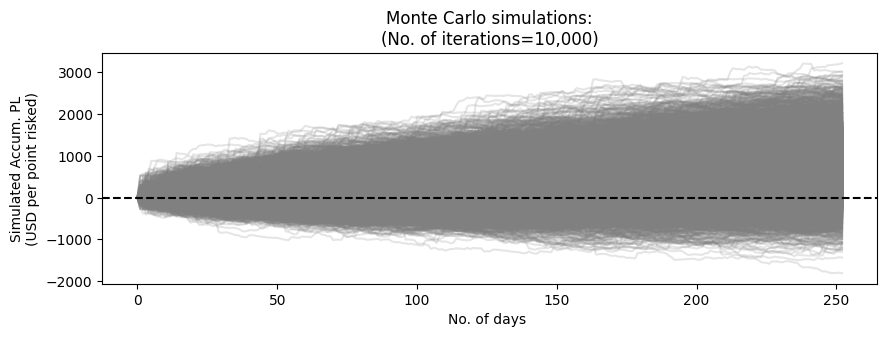

In [17]:
# Plot the MCS
plt.figure(figsize=(10,3))
plt.plot(daily_simulations.T, color='gray', alpha=0.2)
plt.title("Monte Carlo simulations:\n(No. of iterations={:,})".format(daily_simulations.shape[0]))
plt.xlabel("No. of days ")
plt.ylabel("Simulated Accum. PL\n(USD per point risked)") 
plt.axhline(0, color='black', linestyle='--') 
plt.show()